In [1]:
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.manifold import TSNE
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from sklearn.preprocessing import OneHotEncoder as OHE


In [9]:
def get_year(x):
    if pd.isna(x):
        return 0
    else:
        return(int(x[-4:]))

users = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.user', sep='|',
                 names=['user_id','age','gender','occupation','zip_code'])
users = users.drop(['zip_code'],axis=1)


data = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                 names=['user_id','movie_id','rating','tstamp']).sample(frac=1)
data['date'] = pd.to_datetime(data['tstamp'],unit='s')
data = data.drop(['tstamp'],axis=1)

movies = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                    names=['movie_id' ,'movie title' ,'release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western'],encoding='latin')

movies['year'] = movies['release date'].apply(get_year)
movies = movies.drop(['release date','video release date','IMDb URL'],axis=1)

movies = movies.set_index('movie_id')
users = users.set_index('user_id')
num_users = len(pd.unique(data['user_id']))
num_movie = len(pd.unique(data['movie_id']))
data_joined = data.join(movies,on='movie_id',how='inner').join(users,on='user_id',how='inner')
print(data_joined.head())
print(data_joined.dtypes)

       user_id  movie_id  rating                date  \
25679      361       170       5 1997-11-13 17:03:25   
28511      361        53       2 1997-11-13 17:15:51   
25991      361       430       5 1997-11-13 17:01:15   
16798      361       234       4 1997-11-13 17:14:45   
22423      361       813       4 1997-11-13 17:01:15   

                        movie title  unknown  Action  Adventure  Animation  \
25679        Cinema Paradiso (1988)        0       0          0          0   
28511   Natural Born Killers (1994)        0       1          0          0   
25991              Duck Soup (1933)        0       0          0          0   
16798                   Jaws (1975)        0       1          0          0   
22423  Celluloid Closet, The (1995)        0       0          0          0   

       Children  ...  Mystery  Romance  Sci-Fi  Thriller  War  Western  year  \
25679         0  ...        0        1       0         0    0        0  1988   
28511         0  ...        0     

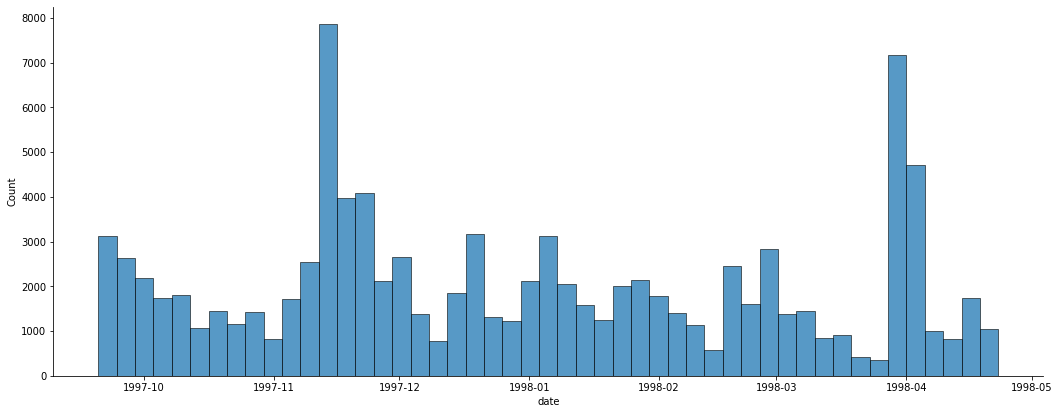

In [10]:
g = sns.displot(data_joined['date'])
g.fig.set_figheight(6)
g.fig.set_figwidth(18)

In [25]:
#Date based split
cutoff_date = '1998-03-01'
df_train = data_joined[data_joined['date'] < cutoff_date]
df_test = data_joined[data_joined['date'] >= cutoff_date]


In [24]:
X_train = df_train[['user_id','movie_id']].to_numpy() - 1
y_train = df_train['rating'].to_numpy()
X_test = df_test[['user_id','movie_id']].to_numpy() - 1
y_test = df_test['rating'].to_numpy()

sns.distplot(X_train[:,1])
sns.distplot(X_test[:,1])

TypeError: cannot perform reduce with flexible type

In [19]:
print(len(np.unique(X_train[:,0])), len(np.unique(X_test[:,0])))
print(len(pd.unique(data['user_id'])))
print(len(np.unique(X_train[:,1])), len(np.unique(X_test[:,1])))
print(len(pd.unique(data['movie_id'])))

736 327
943
1608 1467
1682


In [20]:
def collaborative_model(num_users, num_movies, emb_dim):
    x = tf.keras.Input((2))
    x_user = tf.keras.layers.Embedding(num_users,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='users')(x[:,0])
    x_movie = tf.keras.layers.Embedding(num_movies,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='movies')(x[:,1])
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x, outputs=out, name="colab_model")

model = collaborative_model(num_users,num_movie,32)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=4,
    restore_best_weights=True
)])    
    
umat = model.get_layer('users').get_weights()[0]
mmat = model.get_layer('movies').get_weights()[0]

2022-10-02 20:52:48.085848: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-02 20:52:48.257905: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
2194/2194 [==============================] - 4s 1ms/step - loss: 6.8770 - mse: 6.6959 - val_loss: 14.0810 - val_mse: 13.7030
Epoch 2/40
2194/2194 [==============================] - 3s 1ms/step - loss: 1.5702 - mse: 1.1287 - val_loss: 14.1500 - val_mse: 13.6807
Epoch 3/40
2194/2194 [==============================] - 3s 1ms/step - loss: 1.4574 - mse: 0.9662 - val_loss: 14.1702 - val_mse: 13.6763
Epoch 4/40
2194/2194 [==============================] - 3s 1ms/step - loss: 1.4417 - mse: 0.9366 - val_loss: 14.1775 - val_mse: 13.6744
Epoch 5/40
2194/2194 [==============================] - 3s 1ms/step - loss: 1.4366 - mse: 0.9267 - val_loss: 14.1789 - val_mse: 13.6747
Epoch 6/40
2194/2194 [==============================] - 3s 1ms/step - loss: 1.4326 - mse: 0.9197 - val_loss: 14.1803 - val_mse: 13.6747
Epoch 7/40
2194/2194 [==============================] - 3s 1ms/step - loss: 1.4272 - mse: 0.9129 - val_loss: 14.1830 - val_mse: 13.6732
Epoch 8/40
2194/2194 [==========================

In [21]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set 
y_pred = model(X_test)
tf.keras.metrics.mean_squared_error(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=11.907656>

In [22]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices = np.isin(X_test[:,0],X_train[:,0]) & np.isin(X_test[:,1],X_train[:,1])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
y_pred = model(X_test_seen)
tf.keras.metrics.mean_squared_error(y_test_seen, y_pred)

(3715, 2) (3715,) (22015, 2)


<tf.Tensor: shape=(), dtype=float32, numpy=1.7039118>

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



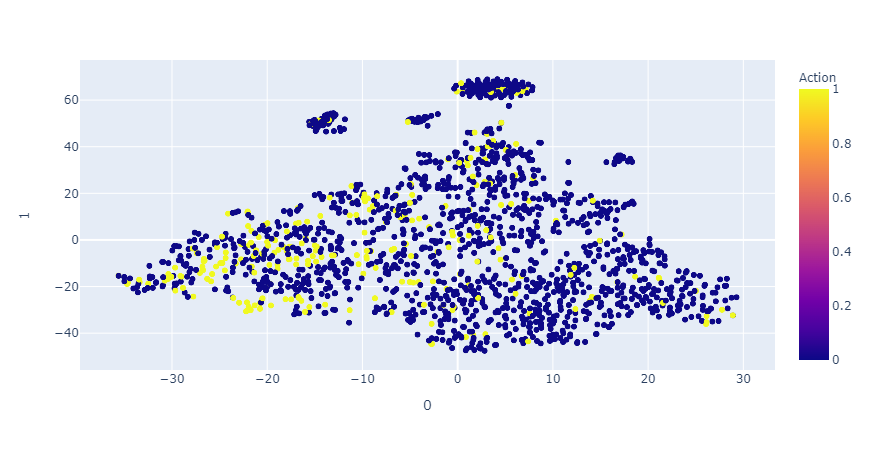

In [58]:
tsne = TSNE()
users = tsne.fit_transform(model.get_layer('users').get_weights()[0])
movies = tsne.fit_transform(model.get_layer('movies').get_weights()[0])
new_df = pd.DataFrame(movies)
new_df[2] = items['movie title'].to_numpy()
new_df.set_index(np.array(new_df.index)+1, inplace = True)
# new_df[3] = items.drop(columns=[0,1,2,3,4]).idxmax(axis=1)
new_df = pd.concat([new_df,items[['release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western']]],axis=1)
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='Action')
fig.show()

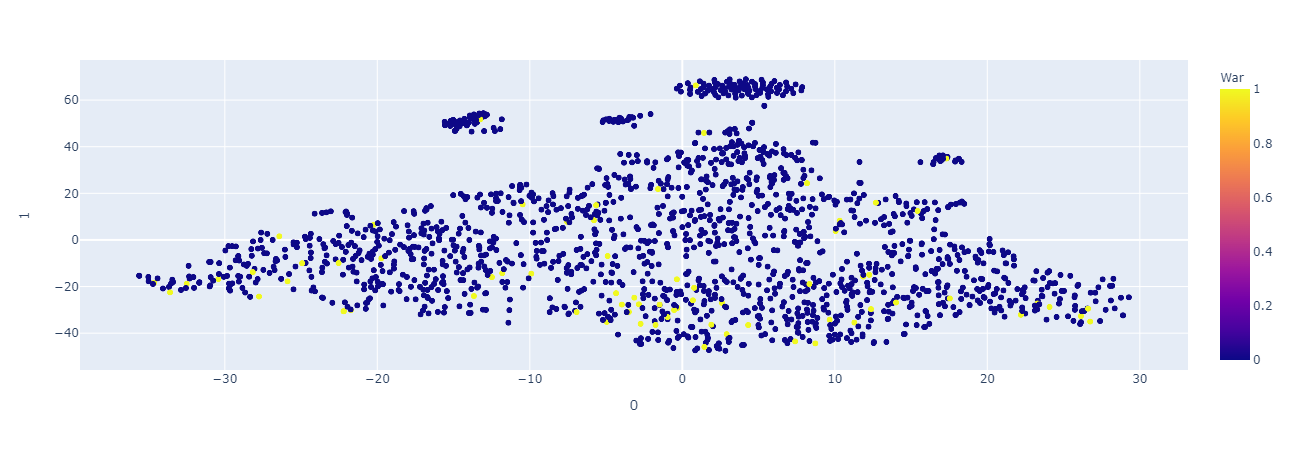

In [61]:
fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color='War')
fig.show()

In [52]:
#train
ohe = OHE(handle_unknown='ignore',sparse=False)
X_train = np.concatenate([df_train.drop(['date','movie_id',
                                           'user_id','movie title',
                                           'rating','gender','occupation'],axis=1),
                         ohe.fit_transform(df_train[['gender','occupation']])],axis=1)

#test
X_test = np.concatenate([df_test.drop(['date','movie_id',
                                           'user_id','movie title',
                                           'rating','gender','occupation'],axis=1),
                         ohe.fit_transform(df_test[['gender','occupation']])],axis=1)

In [53]:
X_train[:,20]

array([22., 22., 22., ..., 33., 33., 33.])

In [61]:
def neural_embeddings_collaborative_model(data_dimension, user_data_start_index, emb_dim):
    x_data = tf.keras.Input((data_dimension))
    x_movie_in = x_data[:,:user_data_start_index]
    x_user_in = x_data[:,user_data_start_index:]
    x_user = tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_user_in)
    x_user = tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_user)
    x_user = tf.keras.layers.Dense(emb_dim,activation='relu')(x_user)
    x_movie = tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_movie_in)
    x_movie = tf.keras.layers.Dense(2*emb_dim,activation='relu')(x_movie)
    x_movie = tf.keras.layers.Dense(emb_dim,activation='relu')(x_movie)
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x_data, outputs=out, name="neural_embeddings_collaborative_model")


model = neural_embeddings_collaborative_model(X_train.shape[1],20,32)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])

model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=4,
    restore_best_weights=True
)])    

Epoch 1/40
2194/2194 [==============================] - 6s 3ms/step - loss: 18582.2656 - mse: 18576.4492 - val_loss: 13.7829 - val_mse: 13.7898
Epoch 2/40
2194/2194 [==============================] - 5s 2ms/step - loss: 13.6498 - mse: 13.6496 - val_loss: 13.7830 - val_mse: 13.7899
Epoch 3/40
2031/2194 [==========================>...] - ETA: 0s - loss: 13.6482 - mse: 13.6482

KeyboardInterrupt: 

In [ ]:
user_df = df[df[0]==eval_user]
user_df[5] = items.iloc[user_df[1].to_numpy()][1].to_numpy()
print(user_df[user_df[2]>3])

In [ ]:
top_10_sorted_movies = tf.argsort(tf.linalg.matmul(mmat,tf.expand_dims(umat[eval_user,:],axis=1)),
                           axis=0,direction='DESCENDING')[:10,0]
items.iloc[top_10_sorted_movies]

In [ ]:
#Add regularization
#split the data as per time


In [ ]:
import seaborn as sns
sns.displot(items[items['year']>1990]['year'])